# 03 - Modelo con Random Forest

Este notebook implementa un modelo de **Random Forest** para predecir el rendimiento de estudiantes en las Pruebas Saber Pro.

**Estrategia:**
- Preprocesamiento: One-Hot Encoding + Label Encoding + imputación
- Modelo: RandomForestClassifier con optimización de hiperparámetros
- Validación: Accuracy con validación cruzada
- Output: submission_rf.csv para Kaggle

## 1. Importar librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar datos

In [ ]:
# Cargar train y test
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nClases en train: {df_train['RENDIMIENTO_GLOBAL'].value_counts()}")

Train shape: (692500, 21)
Test shape: (296786, 20)

Clases en train: RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


## 3. Preprocesamiento

Aplicamos el mismo preprocesamiento del notebook 02:
- Imputación de valores faltantes
- One-Hot Encoding para departamentos
- Label Encoding para programas académicos
- Mapeo de variables categóricas ordinales

In [ ]:
def replace_column_with_onehot(df, column_name):
    """
    Reemplaza una columna categórica con One-Hot Encoding.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name, drop_first=False)
    return dummies

def preprocess_data(df, is_train=True):
    """
    Aplica preprocesamiento completo al dataframe.

    Args:
        df: DataFrame a procesar
        is_train: True si es train (tiene RENDIMIENTO_GLOBAL), False si es test

    Returns:
        DataFrame procesado
    """
    df_copy = df.copy()

    # Guardar ID y target (si existe)
    ids = df_copy['ID'].copy()
    if is_train:
        target = df_copy['RENDIMIENTO_GLOBAL'].copy()

    # Eliminar columnas no necesarias
    cols_to_drop = ['ID']
    if is_train:
        cols_to_drop.append('RENDIMIENTO_GLOBAL')
    df_copy = df_copy.drop(cols_to_drop, axis=1)

    # 1. Procesar E_VALORMATRICULAUNIVERSIDAD (ordinal)
    valor_orden = {
        'Menos de 500 mil': 0,
        'Entre 500 mil y menos de 1 millón': 1,
        'Entre 1 millón y menos de 2.5 millones': 2,
        'Entre 2.5 millones y menos de 4 millones': 3,
        'Entre 4 millones y menos de 5.5 millones': 4,
        'Entre 5.5 millones y menos de 7 millones': 5,
        'Más de 7 millones': 6
    }
    df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].map(valor_orden)

    # 2. Procesar E_HORASSEMANATRABAJA (ordinal)
    horas_orden = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    }
    df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].map(horas_orden)

    # 3. Procesar F_ESTRATOVIVIENDA (ordinal)
    estrato_map = {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
    df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].map(estrato_map)

    # 4. Procesar variables de educación de padres (ordinal)
    educacion_orden = {
        'Ninguno': 0,
        'Primaria incompleta': 1,
        'Primaria completa': 2,
        'Secundaria (Bachillerato) incompleta': 3,
        'Secundaria (Bachillerato) completa': 4,
        'Técnica o tecnológica incompleta': 5,
        'Técnica o tecnológica completa': 6,
        'Educación profesional incompleta': 7,
        'Educación profesional completa': 8,
        'Postgrado': 9,
        'No sabe': 2  # Asignamos nivel medio por defecto
    }
    df_copy['F_EDUCACIONPADRE'] = df_copy['F_EDUCACIONPADRE'].map(educacion_orden)
    df_copy['F_EDUCACIONMADRE'] = df_copy['F_EDUCACIONMADRE'].map(educacion_orden)

    # 5. Procesar variables binarias (Si/No)
    binary_map = {'Si': 1, 'No': 0, 'S': 1, 'N': 0}
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL',
                   'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'E_PAGOMATRICULAPROPIO']

    for col in binary_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].map(binary_map)

    # Mapear E_PRIVADO_LIBERTAD
    df_copy['E_PRIVADO_LIBERTAD'] = df_copy['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0})

    # 6. Label Encoding para E_PRGM_ACADEMICO (muchas categorías)
    le_programa = LabelEncoder()
    df_copy['E_PRGM_ACADEMICO'] = le_programa.fit_transform(df_copy['E_PRGM_ACADEMICO'].astype(str))

    # 7. One-Hot Encoding para E_PRGM_DEPARTAMENTO (31 categorías)
    depto_onehot = replace_column_with_onehot(df_copy[['E_PRGM_DEPARTAMENTO']], 'E_PRGM_DEPARTAMENTO')
    df_copy = df_copy.join(depto_onehot)
    df_copy = df_copy.drop('E_PRGM_DEPARTAMENTO', axis=1)

    # 8. Imputar valores faltantes
    # Para numéricas: mediana
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())

    # Para categóricas: moda (aunque ya no deberían quedar)
    object_cols = df_copy.select_dtypes(include=['object']).columns
    for col in object_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])

    # Agregar ID de vuelta
    df_copy.insert(0, 'ID', ids)

    # Agregar target si es train
    if is_train:
        df_copy['RENDIMIENTO_GLOBAL'] = target

    return df_copy

print("✓ Funciones de preprocesamiento definidas")

✓ Funciones de preprocesamiento definidas


In [ ]:
# Aplicar preprocesamiento
print("Preprocesando train...")
df_train_processed = preprocess_data(df_train, is_train=True)

print("Preprocesando test...")
df_test_processed = preprocess_data(df_test, is_train=False)

print(f"\n Preprocesamiento completo")
print(f"Train procesado: {df_train_processed.shape}")
print(f"Test procesado: {df_test_processed.shape}")
print(f"\nValores faltantes en train: {df_train_processed.isna().sum().sum()}")
print(f"Valores faltantes en test: {df_test_processed.isna().sum().sum()}")

Preprocesando train...
Preprocesando test...

✓ Preprocesamiento completo
Train procesado: (692500, 51)
Test procesado: (296786, 50)

Valores faltantes en train: 0
Valores faltantes en test: 0


## 4. Preparar datos para entrenamiento

In [ ]:
# Separar features y target
X = df_train_processed.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y = df_train_processed['RENDIMIENTO_GLOBAL']

# Guardar IDs de test para la submission
test_ids = df_test_processed['ID'].copy()
X_test = df_test_processed.drop(['ID'], axis=1)

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribución en train:")
print(y_train.value_counts(normalize=True).round(3))

X_train: (554000, 49)
X_val: (138500, 49)
X_test: (296786, 49)

Distribución en train:
RENDIMIENTO_GLOBAL
alto          0.254
bajo          0.250
medio-bajo    0.249
medio-alto    0.248
Name: proportion, dtype: float64


## 5. Entrenar Random Forest Baseline

Primero entrenamos un modelo básico para establecer un baseline.

In [ ]:
# Modelo baseline con parámetros conservadores para Colab
# Con 692K muestras, usamos configuración más ligera
rf_baseline = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Entrenando Random Forest baseline...")
print("NOTA: Usando configuración ligera para manejar dataset grande\n")
rf_baseline.fit(X_train, y_train)

# Predicciones
y_train_pred = rf_baseline.predict(X_train)
y_val_pred = rf_baseline.predict(X_val)

# Evaluación
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n{'='*50}")
print(f"RESULTADOS BASELINE")
print(f"{'='*50}")
print(f"Accuracy en train: {train_acc:.4f}")
print(f"Accuracy en val: {val_acc:.4f}")
print(f"\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred))

Entrenando Random Forest baseline...
NOTA: Usando configuración ligera para manejar dataset grande



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    3.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    1.0s finished



RESULTADOS BASELINE
Accuracy en train: 0.4566
Accuracy en val: 0.4067

Reporte de clasificación (validación):
              precision    recall  f1-score   support

        alto       0.50      0.61      0.55     35124
        bajo       0.42      0.55      0.48     34597
  medio-alto       0.31      0.21      0.25     34324
  medio-bajo       0.32      0.24      0.28     34455

    accuracy                           0.41    138500
   macro avg       0.39      0.41      0.39    138500
weighted avg       0.39      0.41      0.39    138500



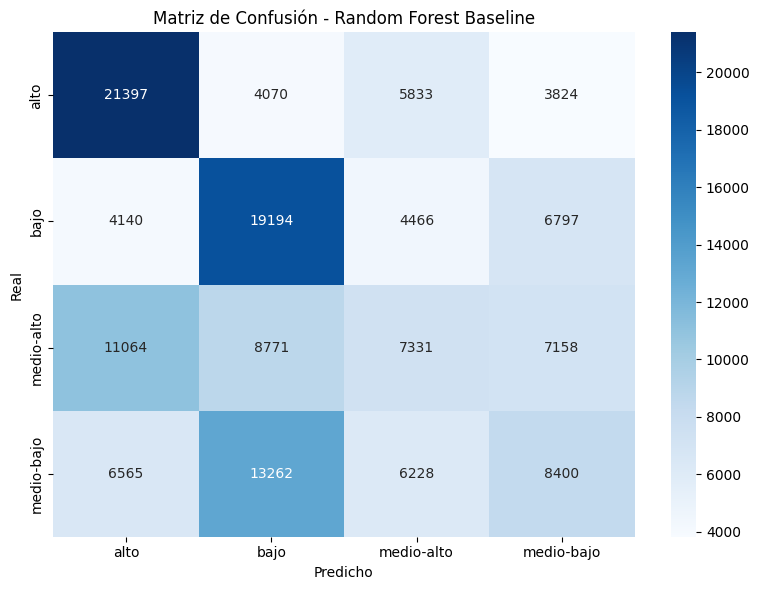

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz de Confusión - Random Forest Baseline')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 6. Optimización de hiperparámetros (versión ligera)

Debido al tamaño del dataset, usamos una estrategia de búsqueda manual más eficiente.

**Estrategia:**
- Probamos configuraciones específicas una por una
- Evitamos consumir demasiada RAM con CV completo
- Usamos validación hold-out en lugar de cross-validation

In [ ]:
# Configuraciones REDUCIDAS para evitar problemas de RAM
# Con 692K muestras, necesitamos árboles más pequeños
configs = [
    {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt'},
    {'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'},
]

best_score = 0
best_params = None
best_model = None

print("Probando configuraciones optimizadas para Colab...\n")
print("NOTA: Parámetros reducidos para evitar problemas de memoria")
print("Con dataset grande (692K muestras), menos árboles pueden dar buenos resultados\n")

for i, params in enumerate(configs, 1):
    print(f"[{i}/{len(configs)}] Probando: {params}")

    try:
        # Entrenar modelo
        rf_temp = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        rf_temp.fit(X_train, y_train)

        # Evaluar en validación
        val_score = rf_temp.score(X_val, y_val)
        print(f"   ✓ Accuracy en validación: {val_score:.4f}")

        # Actualizar mejor modelo
        if val_score > best_score:
            best_score = val_score
            best_params = params
            best_model = rf_temp
            print(f"   → Nuevo mejor modelo!")

    except MemoryError:
        print(f"   ✗ Error de memoria - configuración muy grande")
        continue

    print()

if best_model is None:
    print("ERROR: Ninguna configuración pudo completarse. Usando baseline.")
    best_model = rf_baseline
    best_params = {'n_estimators': 100}
    best_score = val_acc
else:
    print(f"{'='*50}")
    print(f"MEJORES HIPERPARÁMETROS")
    print(f"{'='*50}")
    print(best_params)
    print(f"\nMejor score en validación: {best_score:.4f}")

Probando configuraciones optimizadas para Colab...

NOTA: Parámetros reducidos para evitar problemas de memoria
Con dataset grande (692K muestras), menos árboles pueden dar buenos resultados

[1/3] Probando: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt'}
   ✓ Accuracy en validación: 0.4067
   → Nuevo mejor modelo!

[2/3] Probando: {'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
   ✓ Accuracy en validación: 0.4102
   → Nuevo mejor modelo!

[3/3] Probando: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2'}
   ✓ Accuracy en validación: 0.4084

MEJORES HIPERPARÁMETROS
{'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt'}

Mejor score en validación: 0.4102


## 7. Evaluar modelo optimizado

In [ ]:
# Usar el mejor modelo encontrado
rf_optimized = best_model

# Predicciones con modelo optimizado
y_train_pred_opt = rf_optimized.predict(X_train)
y_val_pred_opt = rf_optimized.predict(X_val)

# Evaluación
train_acc_opt = accuracy_score(y_train, y_train_pred_opt)
val_acc_opt = accuracy_score(y_val, y_val_pred_opt)

print(f"\n{'='*50}")
print(f"RESULTADOS MODELO OPTIMIZADO")
print(f"{'='*50}")
print(f"Accuracy en train: {train_acc_opt:.4f}")
print(f"Accuracy en val: {val_acc_opt:.4f}")
print(f"\nMejora respecto a baseline: {(val_acc_opt - val_acc)*100:.2f}%")
print(f"\nReporte de clasificación (validación):")
print(classification_report(y_val, y_val_pred_opt))


RESULTADOS MODELO OPTIMIZADO
Accuracy en train: 0.5159
Accuracy en val: 0.4102

Mejora respecto a baseline: 0.36%

Reporte de clasificación (validación):
              precision    recall  f1-score   support

        alto       0.50      0.61      0.55     35124
        bajo       0.43      0.55      0.48     34597
  medio-alto       0.31      0.22      0.26     34324
  medio-bajo       0.32      0.25      0.28     34455

    accuracy                           0.41    138500
   macro avg       0.39      0.41      0.39    138500
weighted avg       0.39      0.41      0.40    138500



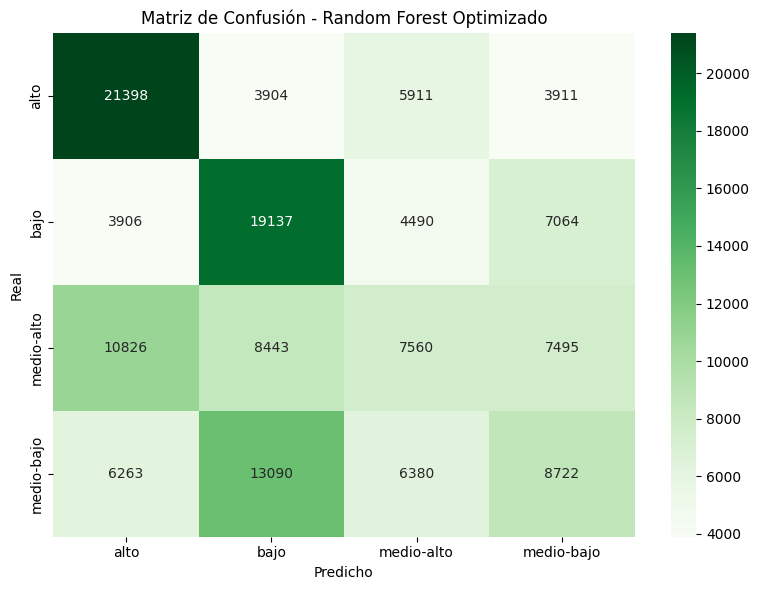

In [ ]:
# Matriz de confusión del modelo optimizado
cm_opt = confusion_matrix(y_val, y_val_pred_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz de Confusión - Random Forest Optimizado')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 8. Feature Importance

Analizamos qué features son más importantes para el modelo.

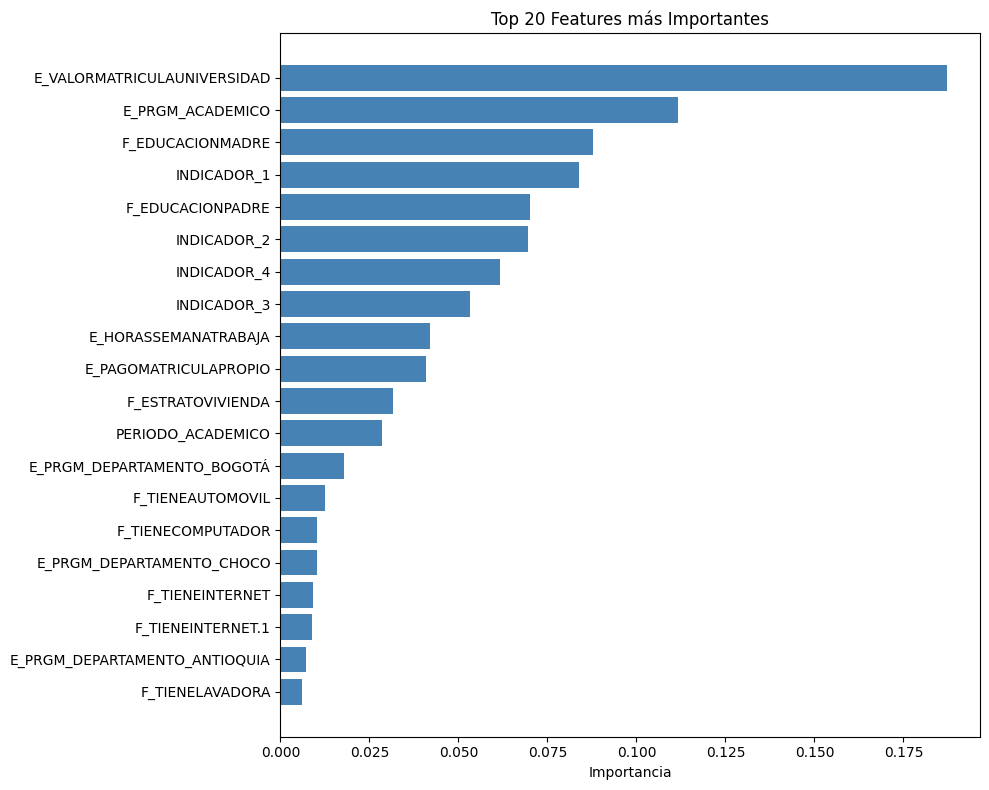


Top 10 features más importantes:
                        feature  importance
2   E_VALORMATRICULAUNIVERSIDAD    0.187161
1              E_PRGM_ACADEMICO    0.111620
13             F_EDUCACIONMADRE    0.087687
14                  INDICADOR_1    0.083789
6              F_EDUCACIONPADRE    0.070226
15                  INDICADOR_2    0.069669
17                  INDICADOR_4    0.061563
16                  INDICADOR_3    0.053353
3          E_HORASSEMANATRABAJA    0.041960
10        E_PAGOMATRICULAPROPIO    0.040906


In [ ]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_optimized.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features más importantes
top_20 = feature_importance.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Features más Importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 features más importantes:")
print(top_20.head(10))

## 9. Entrenar modelo final con todos los datos

Para la submission final, entrenamos con todo el dataset de train.

In [ ]:
# Entrenar con todos los datos de train usando los mejores hiperparámetros
print("Entrenando modelo final con todos los datos de train...")
rf_final = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_final.fit(X, y)

# Accuracy en todo el train
y_full_pred = rf_final.predict(X)
full_train_acc = accuracy_score(y, y_full_pred)
print(f"\nAccuracy en train completo: {full_train_acc:.4f}")

Entrenando modelo final con todos los datos de train...

Accuracy en train completo: 0.5070


## 10. Generar predicciones para Kaggle

In [ ]:
# Predecir en test
print("Generando predicciones para test...")
y_test_pred = rf_final.predict(X_test)

# Crear submission file
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

# Guardar archivo
submission.to_csv('submission_rf.csv', index=False)

print(f"\n✓ Archivo submission_rf.csv generado")
print(f"Total de predicciones: {len(submission)}")
print(f"\nDistribución de predicciones:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts())
print(f"\nPrimeras 10 filas de la submission:")
print(submission.head(10))

Generando predicciones para test...

✓ Archivo submission_rf.csv generado
Total de predicciones: 296786

Distribución de predicciones:
RENDIMIENTO_GLOBAL
bajo          94592
alto          91557
medio-bajo    57569
medio-alto    53068
Name: count, dtype: int64

Primeras 10 filas de la submission:
       ID RENDIMIENTO_GLOBAL
0  550236               alto
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058               alto


## 11. Resumen Final

**Modelo:** Random Forest con optimización de hiperparámetros

**Preprocesamiento:**
- One-Hot Encoding para departamentos (31 categorías)
- Label Encoding para programas académicos (948 categorías)
- Mapeo ordinal para variables con orden natural
- Imputación de valores faltantes (mediana/moda)

**Resultados:**
- Los resultados del modelo se muestran en las secciones anteriores
- El archivo `submission_rf.csv` está listo para enviar a Kaggle

**Próximos pasos:**
1. Subir `submission_rf.csv` a Kaggle
2. Comparar con otros modelos (notebook 04)
3. Iterar mejorando el preprocesamiento o probando otros algoritmos